## Everlasting Options: Empirical Backtest
**Objective**: In this analysis we're backtesting the theoretical value of a 50k BTC everlasting call option over a two month period. Please refer to this [paper](https://www.paradigm.xyz/2021/05/everlasting-options/) by [Dave White](https://twitter.com/_Dave__White_) and [Sam Bankman-Fried](https://twitter.com/SBF_Alameda) for the exact details and methodology. 

A special thanks to Dave for helping me understand how everlasting options are priced and debugging this notebook code.

#### Introduction
Everlasting options are a new type of financial derivative which don't expire. This is especially useful for traders who wish to maintain their position but don't want to continuously roll their positions. Similar to perpetual futures contracts, we can think of everlasting options as perpetual option contracts.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from os import listdir
from datetime import datetime

#### Data: 

- For this analysis we first need to query the historical price data for Deribit 50k BTC call options across all maturities on a daily basis. For example, the data on [2021-03-03](https://github.com/schepal/everlasting_option_analysis/blob/main/data/option_data/2021-03-03%2009:00:00.csv) shows the USD price of the 50k BTC call option for each maturity.
- We'll also need the Deribit BTC index price to calculate the theoretical value of the everlasting option on a daily basis. 

In [2]:
# Load pre-formatted historical options data for the $50k call option strike
directory = "data/option_data/"
files = sorted(listdir(directory))[1:]
dates = [datetime.strptime(files[i], "%Y-%m-%d %H:%M:%S.csv") for i in range(len(files))]
master_data = pd.DataFrame([dates, files]).T
master_data.columns = ['date', 'file_name']
master_data.head()

,date,file_name
0,2021-03-02 09:00:00,2021-03-02 09:00:00.csv
1,2021-03-03 09:00:00,2021-03-03 09:00:00.csv
2,2021-03-04 09:00:00,2021-03-04 09:00:00.csv
3,2021-03-05 09:00:00,2021-03-05 09:00:00.csv
4,2021-03-06 09:00:00,2021-03-06 09:00:00.csv


In [3]:
# Load spot price of BTC (based on Deribit BTC index price)
spot = pd.read_csv("data/btc_spot.csv", index_col=0, parse_dates=True)
spot.head()

,btc_index_price
date,
2021-03-01 09:00:00,47091.52
2021-03-02 09:00:00,48901.26
2021-03-03 09:00:00,50957.43
2021-03-04 09:00:00,50241.38
2021-03-05 09:00:00,46629.71


One of the issues with the current Deribit data is that the maturities are not equally spaced with one day between each maturity. The data on [2021-03-03](https://github.com/schepal/everlasting_option_analysis/blob/main/data/option_data/2021-03-03%2009:00:00.csv) has only 10 option maturities, however, in order to accurately calculate the everlasting option price we need to interpolate the data so we have maturities incremented on a daily basis. In other words we'll need to have price data for maturities across nearly 300 days (ie: 1, 2, 3, 4 .... 303 days left).

In [4]:
def interpolate_data(data):    
    """
    Interpolates the option prices between each expiry to ensure there is at least 
    one day between each observation.
    
    Parameters:
    -----------
    data: pd.DataFrame
        The non-interpolated option data as referenced in the `master_data` dataframe
        
    Returns:
    ----------
    res: pd.DataFrame
        The interpolated dataframe with increments of one day between all maturities.    
    """    
    data['days_left'] = round(data.days_left)
    # Start interpolating on a daily basis from the earliest maturity to the last maturity
    days = np.arange(data.days_left.iloc[0], data.days_left.iloc[-1]+1, 1)
    # Create a new dataframe to store the interpolated results
    res = pd.DataFrame(days)
    res.columns = ['days_left']
    # Perform simple 1d interpolation
    interpolate_function = interpolate.interp1d(data.days_left, data.usd_price, fill_value='extrapolate')
    res['price'] = interpolate_function(days)
    return res

The price of the everlasting option itself is relatively simple with exponential weighted arithmetic averaging. In other words, the 1 day option will make up roughly 50% of the everlasting price, the 2 day option will make up roughly 25% and so on as shown below:

Option 1: ${0.50^1}$ = 0.50

Option 2: ${0.50^2}$ = 0.25

Option 3: ${0.50^3}$ = 0.125

etc...


The plot below can help explain how much weight each option receives in an everlasting option. It's interesting to see that going beyond five options has a trivial impact on the overall everlasting option. In fact nearly 97% of the everlasting option weighting comes from these first five maturities.

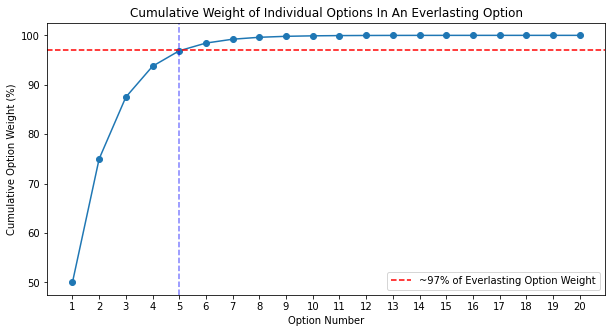

In [5]:
plt.figure(figsize=(10, 5))
option_number = range(1, 21, 1)
plt.plot(option_number, np.cumsum([(0.50**i*100) for i in option_number]), marker='o')
plt.xlabel("Option Number")
plt.ylabel("Cumulative Option Weight (%)")
plt.axhline(97, label='~97% of Everlasting Option Weight', c='r', linestyle='--')
plt.axvline(5,  c='b', linestyle='--', alpha=0.50)
plt.xticks(option_number)
plt.title("Cumulative Weight of Individual Options In An Everlasting Option")
plt.legend()
plt.savefig("figures/cumulative_weight.png", dpi=300)

In [6]:
def get_option_price(data):
    """
    Returns the price of the everlasting option.
    
    Parameters:
    -----------
    data: pd.DataFrame
        The interpolated dataframe output from the `interpolate_data` function.
        
    Returns:
    ----------
    float
        The price of the everlasting option
    """
    # Weigh each option by it's days left to maturity
    weights = 0.50**data.days_left
    # Calculate the current price of the option
    return sum(data.price*weights)

The code below simply loops through each daily observation to calculate several values including:
- The price of the everlasting option **before** paying the funding fee
- The price of the everlasting option **after** paying the funding fee
- The funding fee

Note: there is a jump discontinuity which occurs the moment right before the funding fee is paid. In other words, the funding fee represents the jump for the price of the everlasting option right after the fee is paid. Please see the appendix below for further details.

In [7]:
# Recall we're analyzing a $50k everlasting call option 
strike = 50_000
store = []

# For each daily observation, we calculate the daily everlasting option price and funding fee
for observation in range(len(master_data)):
    # Read the each daily observation
    date = master_data.date.iloc[observation]
    data = pd.read_csv(directory + master_data.file_name.iloc[observation], index_col=0)            
    '''
    Note: In some rare cases, the data will be missing for 1 day options. The if/else logic is used to
    address this missing data. These skipped obsevations will be linearly interpolated.
    '''
    # If the earliest option maturity (rounded) has 1 day left then we're looking at the correct data
    if round(data.days_left.iloc[0]) == 1.0:
        # Interpolate the data for the given date
        results = interpolate_data(data)
        # Get the spot price for the given date
        spot_price = float(spot.loc[date])
        # Get the price of the everlasting option *AFTER* the funding fee payment
        everlasting_price_after = get_option_price(results)        
        # Get the payoff of the everlasting option
        payoff = max(spot_price - strike, 0)
        # Get the price of the option *BEFORE* the funding payment
        everlasting_price_before = (everlasting_price_after + payoff) / 2
        # The funding fee is simply the difference between the "AFTER" and "BEFORE" option price
        funding_fee = everlasting_price_after - everlasting_price_before        
        store.append([date, everlasting_price_after, funding_fee, spot_price])        

    else:
        # If the earliest option maturity is different from 1 days to maturity, this suggests missing data.
        # Skip this observation as we will linearly interpolate this data point
        pass

In [8]:
# Save the output into dataframe format
df = pd.DataFrame(store)
df.columns = ['date', 'option_price', 'funding_fee', 'spot_price']
df.index = df.date
df = df.drop("date", axis=1)
# Resample and linearly interpolate to address any missing values
df = df.resample("D").mean()
df = df.interpolate()
df.head()

,option_price,funding_fee,spot_price
date,,,
2021-03-02,701.151209,350.575605,48901.26
2021-03-03,1719.818933,381.194467,50957.43
2021-03-04,1284.711729,521.665864,50241.38
2021-03-05,269.065565,134.532783,46629.71
2021-03-06,598.265373,299.132687,48643.31


We can see the price of the everlasting 50k call option is quite volatile. This is somewhat expected given 75% of this option's price behaviour is dictated by 1 and 2 day options which are known to be exceptionally volatile (ie: short-dated options are at their peak gamma when the underlying price is near the strike).

Dave brought up an insightful point that between 2021-03-01 to around 2021-04-15, the everlasting option traded similar to spot BTC. This makes sense because during this time the everlasting option was in-the-money which corresponds to a larger delta profile.

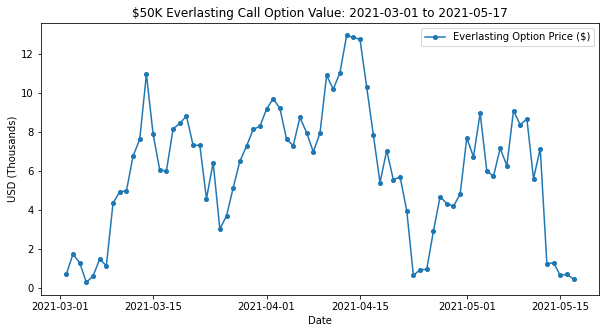

In [9]:
# Plot the everlasting option price
plt.figure(figsize=(10, 5))
plt.plot(df.option_price/1000, marker='o' , markersize=4, label='Everlasting Option Price ($)')
plt.title("\$50K Everlasting Call Option Value: 2021-03-01 to 2021-05-17")
plt.xlabel("Date")
plt.ylabel("USD (Thousands)")
plt.legend()
plt.savefig("figures/everlasting_call_price.png", dpi=300)

Furthermore, it's interesting to see that periods of high volatility in the everlasting option are accompanied by large swings in the funding fee. This makes sense because the funding fee itself is largely driven by the price of the basket of options. 

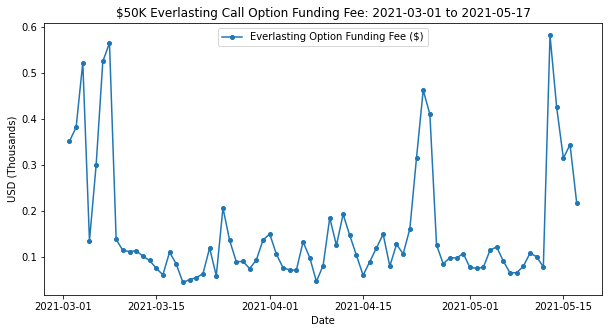

In [10]:
# Plot the everlasting option funding fee
plt.figure(figsize=(10, 5))
plt.plot(df.funding_fee/1000, marker='o' , markersize=4, label='Everlasting Option Funding Fee ($)')
plt.title("\$50K Everlasting Call Option Funding Fee: 2021-03-01 to 2021-05-17")
plt.xlabel("Date")
plt.ylabel("USD (Thousands)")
plt.legend()
plt.savefig("figures/funding_fee.png", dpi=300)

An area of future research could be to explore floating strike everlasting options as these would likely be the most realsitic way for this product to gain popularity amongst traders and market-makers. 

#### Appendix: Everlasting Option Funding Fee Diagram

<img src="figures/appendix_diagram.png" width="800" />

Under the approach in the backtest, we’re finding the price of the everlasting option after the funding fee has been paid which is represented by $M_1$. Therefore, we have to calculate the price of the everlasting option at $M_0$ (before the funding payment) to determine the funding fee. This involves some simple algebra:


$$M_1 = 2(M_0 - P) + P$$
$$M_1 = 2M_0 - 2P + P$$ 
$$M_1 = 2M_0 - P$$ 
$$M_0 = (M_1 + P)/2$$ 
$$\text{Funding Fee} = M_1 - M_0$$


Therefore, we can simply state the funding fee is the difference between the option price before funding and the option price instantaneously after funding.